## Imports & Declarations

In [1]:
# wrap all imports together
from allimport_xai_v3 import *
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

random_state = 1234
np.random.seed(random_state)
random.seed(random_state)
tf.random.set_seed(random_state)

c:\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre-defined Parameters

### Display Configuration

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


### Data Input

In [3]:
# input file
train_file = 'DP_Phase4_combined_v3_train.csv'
test_file = 'DP_Phase4_combined_v3_test.csv'
class1_file = 'DP_Phase4_2019_ALL.csv'

# Model files
model_name = '3m'
features_file = 'saved_model/featurelist_{}.csv'.format(model_name)
scaler_file = 'saved_model/scaler_{}.pkl'.format(model_name)
model_file = 'saved_model/phase4_{}_model'.format(model_name)
kmeans_file = 'saved_model/kmeans_{}.pkl'.format(model_name)
featdict_file = 'saved_model/features_dict_{}.pkl'.format(model_name)

target_col = [
    'Cerebral_Vascular_Accident', 'Diabetes_Mellitus',
    'Dyslipidaemia', 'Heart_and_Circulatory', 'Hypertension',
    'Osteoporosis', 'Renal_Disease', 'Osteoarthritis', 'Deceased'
]

prior_diag_col = ["Cerebral_Vascular_Accident_Diagnosed","Cerebral_Vascular_Accident_Medication",
                  "Cerebral_Vascular_Accident_Test","Diabetes_Mellitus_Diagnosed","Diabetes_Mellitus_Medication",
                  "Diabetes_Mellitus_Test","Dyslipidaemia_Diagnosed","Dyslipidaemia_Medication","Dyslipidaemia_Test",
                  "Heart_and_Circulatory_Diagnosed","Heart_and_Circulatory_Medication","Heart_and_Circulatory_Test",
                  "Hypertension_Diagnosed","Hypertension_Medication","Hypertension_Test","Osteoporosis_Diagnosed",
                  "Osteoporosis_Medication","Osteoporosis_Test","Osteoarthritis_Diagnosed","Osteoarthritis_Medication",
                  "Osteoarthritis_Test","Renal_Disease_Diagnosed","Renal_Disease_Medication","Renal_Disease_Test",
                  "Deceased_Diagnosed","Deceased_Medication","Deceased_Test"
]

prior_diag_drop = ["Cerebral_Vascular_Accident_Test", "Cerebral_Vascular_Accident_Medication",
                  "Heart_and_Circulatory_Medication", "Heart_and_Circulatory_Test",
                  "Hypertension_Test",
                  "Osteoporosis_Test",
                  "Osteoarthritis_Medication", "Osteoarthritis_Test",
                  "Renal_Disease_Medication",
                  "Deceased_Diagnosed","Deceased_Medication","Deceased_Test"
]

target_prior_col = [target+'_Prior' for target in target_col[:-1]]

# SHAP parameters
non_periodic_features = ['PAT_AGE', 'GENDER_Male', 'GENDER_Female', 
                         'RACE_Chinese', 'RACE_Malay', 'RACE_Indian', 'RACE_Others',
                         "Cancer_Prior","Cerebral_Vascular_Accident_Prior","Diabetes_Mellitus_Prior",
                         "Dyslipidaemia_Prior","Heart_and_Circulatory_Prior","Hypertension_Prior",
                         "Osteoporosis_Prior","Renal_Disease_Prior","OverWeight_Prior",
                         "Osteoarthritis_Prior","BPH_Prior","COPD_Prior","Epilepsy_Prior","HepB_Prior",
                         "Parkinson_Prior","Psoriasis_Prior","RA_Prior","Allergic_Prior","Asthma_Prior",
                         "Dementia_Prior","Gout_Prior"
] + prior_diag_col

# features to drop
feature_to_drop = ['PAT_ID'] + target_col + target_prior_col + prior_diag_drop

# validation data size
val_size=60800

BATCH_SIZE = 512

## Import data

In [4]:
# data files
feature_names = pd.read_csv(features_file)['Feature name'].tolist()
train = pd.read_csv(train_file, usecols=feature_to_drop+feature_names)
test = pd.read_csv(test_file, usecols=feature_to_drop+feature_names)

class1_data = pd.read_csv(class1_file, usecols=feature_to_drop+feature_names)
train = pd.concat([train, class1_data], axis=0, ignore_index=True).reset_index(drop=True)

In [5]:
# del class1_data
# gc.collect()

In [6]:
test = test.reset_index(drop=True)

gc.collect()

42

In [7]:
test.shape

(75737, 305)

## Load Model and Scaler

In [8]:
model = keras.models.load_model(model_file, compile=False)
scaler = load(open(scaler_file, 'rb'))

Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


In [9]:
model.summary()

Model: "Model_3m"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 275)]             0         
                                                                 
 hidden1 (Dense)             (None, 1024)              282624    
                                                                 
 hidden2 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 output_layer (Dense)        (None, 9)                 4617      
                                                                 
Total params: 812,041
Trainable params: 812,041
Non-trainable params: 0
_________________________________________________________________


## Process Data

In [10]:
# Define process function, combine scaler
def data_proc_X(data, feature_names, scaler_file=None):
    X = data[feature_names]
    X.fillna(-1, inplace=True)  # Fill in missing with -1
    X = np.asarray(X)  # Convert to array
    
    if scaler_file is None:
        X = X
    else:
        scaler = load(open(scaler_file, 'rb'))  # Load scaler
        X = scaler.transform(X)  # Scale data
    return X

def data_proc_y(data, target_col):
    # Form np arrays of labels
    y = np.asarray(data[target_col])   
    return y

## Prediction & Evaluation

In [11]:
target_prior_col = [target + '_Prior' for target in target_col[:-1]]
target_proba_col = [target + '_Proba' for target in target_col]

In [12]:
# create dataframe with target prior, target label and target probability
def create_target_df(target_prior_col, feature_names, target_col,
                     features_data, labels_data, predictions_data, data):
    
    # create data frame with target prior
    df = data[target_prior_col].copy()
    df['Deceased_Prior'] = 0

    # add target labels, prediction probabilities
    for i, target in enumerate(target_col):
        # label is 3-class, only the second class tell if it is new onset
        df[target] = labels_data[:, i] 
        
        # exclude class 2 prediction probabilities to only include class 1 and 0
        df[target+'_Proba'] = predictions_data[:, i]
        
    return df

In [13]:
# create dataframe with all combinations of f1
def create_f1_df(target_prior_col, target_proba_col, feature_names, target_col,
                 features_data, labels_data, predictions_data, data, remove_prior=False):

    # Create dataframe with prior disease, target labels and probability
    target_df = create_target_df(target_prior_col, feature_names, target_col,
                                 features_data, labels_data, predictions_data, data)

    # Create metrics for different threshold and different disease
    # Remove records with prior target disease when analyzing target diseases
    f1_df = pd.DataFrame()
    total_samples = len(target_df)
    range_i = np.linspace(0.1, 0.6, 51)
    for j, target in enumerate(target_col):
        if remove_prior:
            # remove those with prior diagnosis for the target
            df = target_df[target_df[target + '_Prior'] == 0]
        else:
            # do not remove those with prior diagnosis for the target
            df = target_df.copy()
            df[target] = np.where(df[target + '_Prior']==1, 1, df[target])

        # create dataframe with metrics
        tmp = pd.DataFrame({
            'Target': [target for i in range_i],
            'ROC-AUC': [roc_auc_score(df[target], df[target_proba_col[j]]) for i in range_i],
            'Threshold': [i for i in range_i],
            'F1': [f1_score(df[target], df[target_proba_col[j]] > i) for i in range_i],
            'Precision':[precision_score(df[target], df[target_proba_col[j]] > i) for i in range_i],
            'Recall':[recall_score(df[target], df[target_proba_col[j]] > i) for i in range_i],
            'Specificity':[recall_score(df[target], df[target_proba_col[j]] > i, pos_label=0) for i in range_i],
            'Accuracy':[accuracy_score(df[target], df[target_proba_col[j]] > i) for i in range_i],
            'Test_samples':[len(df) for i in range_i],
            'Test_positive':[len(df[df[target] == 1]) for i in range_i],
            'Total_samples':[total_samples for i in range_i],
        })

        f1_df = pd.concat([f1_df, tmp], ignore_index=True)


    return f1_df

In [14]:
# create dataframe with max f1 and metrics
def create_metrics_df(target_prior_col, target_proba_col, feature_names,
                      target_col, features_data, labels_data,
                      predictions_data, data, remove_prior=False):

    f1_df = create_f1_df(target_prior_col, target_proba_col, feature_names,
                         target_col, features_data, labels_data,
                         predictions_data, data, remove_prior)

    max_f1_df = pd.DataFrame(columns=[
        'Target', 'ROC-AUC', 'Threshold', 'F1', 'Precision', 'Recall','Specificity', 'Accuracy',
        'Test_samples', 'Test_positive'
    ])

    for target in target_col:
        df = f1_df[f1_df['Target'] == target].copy()

        ind = df['F1'].idxmax()
        max_f1_df = max_f1_df.append(
            {
                'Target': target,
                'ROC-AUC': df.loc[ind, 'ROC-AUC'],
                'Threshold': df.loc[ind, 'Threshold'],
                'F1': df.loc[ind, 'F1'],
                'Precision': df.loc[ind, 'Precision'],
                'Recall': df.loc[ind, 'Recall'],
                'Specificity': df.loc[ind, 'Specificity'],
                'Accuracy': df.loc[ind, 'Accuracy'],
                'Test_samples': df.loc[ind, 'Test_samples'],
                'Test_positive': df.loc[ind, 'Test_positive'],
                'Total_samples': df.loc[ind, 'Total_samples']
            },
            ignore_index=True)

    return max_f1_df

In [15]:
def evaluate_model(data, remove_prior=False):
    
    features = data_proc_X(data, feature_names, scaler_file=scaler_file)
    labels = data_proc_y(data, target_col)
    predictions = model.predict(features, batch_size=BATCH_SIZE)
    
    max_f1 = create_metrics_df(target_prior_col, target_proba_col,
                                feature_names, target_col, features,
                                labels, predictions, data, remove_prior)
    
    # remove deceased
    max_f1 = max_f1[max_f1['Target']!='Deceased']
    return max_f1

## Evaluate

In [16]:
test_max_f1 = evaluate_model(test, remove_prior=True)
test_max_f1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.855252,0.14,0.272473,0.247261,0.303409,0.973281,0.954449,74092,2083,75737.0
1,Diabetes_Mellitus,0.838226,0.22,0.437505,0.426104,0.449532,0.933320,0.885325,62516,6202,75737.0
2,Dyslipidaemia,0.810463,0.21,0.407294,0.308869,0.597787,0.812712,0.786315,50041,6146,75737.0
3,Heart_and_Circulatory,0.872058,0.21,0.468756,0.468570,0.468942,0.959775,0.925263,71665,5039,75737.0
4,Hypertension,0.784241,0.18,0.366319,0.271128,0.564519,0.818513,0.791383,51875,5541,75737.0
5,Osteoporosis,0.878895,0.11,0.234322,0.172213,0.366498,0.956644,0.942469,74065,1779,75737.0
6,Renal_Disease,0.856271,0.20,0.402535,0.347997,0.477344,0.938381,0.908664,69162,4458,75737.0
7,Osteoarthritis,0.817184,0.19,0.392944,0.322606,0.502506,0.895188,0.859706,72854,6583,75737.0


In [17]:
test_max_f1['F1'].mean(), test_max_f1['ROC-AUC'].mean()

(0.37276848479981795, 0.8390738533040678)

In [18]:
train_max_f1 = evaluate_model(train, remove_prior=True)
train_max_f1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.857427,0.14,0.283617,0.255631,0.318483,0.972357,0.953431,3491299,101054,3574596.0
1,Diabetes_Mellitus,0.825189,0.21,0.413851,0.355753,0.494628,0.897569,0.856220,2937804,301473,3574596.0
2,Dyslipidaemia,0.809959,0.21,0.415112,0.319384,0.592786,0.813850,0.785458,2342532,300859,3574596.0
3,Heart_and_Circulatory,0.871814,0.23,0.469223,0.481363,0.457681,0.963531,0.928696,3363624,231631,3574596.0
4,Hypertension,0.782536,0.19,0.370492,0.280154,0.546819,0.826129,0.795371,2435235,268171,3574596.0
5,Osteoporosis,0.882899,0.11,0.247614,0.181032,0.391666,0.955201,0.941304,3483924,85915,3574596.0
6,Renal_Disease,0.856507,0.19,0.400097,0.337527,0.491143,0.931676,0.902518,3256592,215542,3574596.0
7,Osteoarthritis,0.821843,0.20,0.401254,0.339333,0.490818,0.903743,0.865956,3410247,312075,3574596.0


In [19]:
train_max_f1['F1'].mean(), train_max_f1['ROC-AUC'].mean()

(0.3751574366721217, 0.8385216265228812)

In [25]:
demographics_test = pd.DataFrame()
for col in ['GENDER_Male', 'GENDER_Female', 'RACE_Chinese', 'RACE_Malay', 'RACE_Indian', 'RACE_Others']:
    tmp = pd.DataFrame({'Demographics': col,
                        'Test': len(test[test[col]==1])}, index=[0])
    demographics_test = pd.concat([demographics_test, tmp], ignore_index=True)
    
tmp = pd.DataFrame({'Demographics': 'Below50',
                        'Test': len(test[test['PAT_AGE']<50])}, index=[0])
demographics_test = pd.concat([demographics_test, tmp], ignore_index=True)
    
tmp = pd.DataFrame({'Demographics': 'Above50',
                        'Test': len(test[test['PAT_AGE']>=50])}, index=[0])
demographics_test = pd.concat([demographics_test, tmp], ignore_index=True)

In [26]:
demographics_train = pd.DataFrame()
for col in ['GENDER_Male', 'GENDER_Female', 'RACE_Chinese', 'RACE_Malay', 'RACE_Indian', 'RACE_Others']:
    tmp = pd.DataFrame({'Demographics': col,
                        'Train': len(train[train[col]==1])}, index=[0])
    demographics_train = pd.concat([demographics_train, tmp], ignore_index=True)
    
tmp = pd.DataFrame({'Demographics': 'Below50',
                        'Train': len(train[train['PAT_AGE']<50])}, index=[0])
demographics_train = pd.concat([demographics_train, tmp], ignore_index=True)
    
tmp = pd.DataFrame({'Demographics': 'Above50',
                        'Train': len(train[train['PAT_AGE']>=50])}, index=[0])
demographics_train = pd.concat([demographics_train, tmp], ignore_index=True)

In [27]:
demographics_test['test_total'] = len(test)
demographics_train['train_total'] = len(train)

demographics_combined = demographics_train.merge(demographics_test, how='inner', on='Demographics')
demographics_combined['Overall'] = demographics_combined['Train']  + demographics_combined['Test']
demographics_combined['overall_total'] = demographics_train['train_total'] + demographics_test['test_total']
demographics_combined

,Demographics,Train,train_total,Test,test_total,Overall,overall_total
0,GENDER_Male,1726198,3574596,36652,75737,1762850,3650333
1,GENDER_Female,1848398,3574596,39085,75737,1887483,3650333
2,RACE_Chinese,2524001,3574596,53658,75737,2577659,3650333
3,RACE_Malay,438734,3574596,9299,75737,448033,3650333
4,RACE_Indian,278677,3574596,5843,75737,284520,3650333
5,RACE_Others,333184,3574596,6937,75737,340121,3650333
6,Below50,1599580,3574596,34107,75737,1633687,3650333
7,Above50,1975016,3574596,41630,75737,2016646,3650333


In [20]:
for col in ['GENDER_Male', 'GENDER_Female', 'RACE_Chinese', 'RACE_Malay', 'RACE_Indian', 'RACE_Others']:
    print(f"{col} == 1")
    print("TRAIN RESULTS")
    tmp = evaluate_model(train[train[col]==1], remove_prior=True)
    display(tmp)
    print(tmp['F1'].mean(), tmp['ROC-AUC'].mean())
    print()
    print("TEST RESULTS")
    tmp = evaluate_model(test[test[col]==1], remove_prior=True)
    display(tmp)
    print(tmp['F1'].mean(), tmp['ROC-AUC'].mean())
    print("----------------------------------------------------------------------------------------------")
    print()

GENDER_Male == 1
TRAIN RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.848803,0.14,0.282376,0.259128,0.310208,0.969609,0.947763,1678071,55595,1726198.0
1,Diabetes_Mellitus,0.831630,0.21,0.418532,0.347852,0.525257,0.882021,0.843851,1401060,149898,1726198.0
2,Dyslipidaemia,0.804244,0.22,0.421026,0.331104,0.578000,0.815215,0.782805,1118230,152782,1726198.0
3,Heart_and_Circulatory,0.871580,0.26,0.511842,0.544839,0.482613,0.961733,0.920200,1591051,137922,1726198.0
4,Hypertension,0.793556,0.20,0.385443,0.286366,0.589344,0.808250,0.782970,1143561,132062,1726198.0
5,Osteoporosis,0.862328,0.10,0.138246,0.131606,0.145592,0.989564,0.980495,1711032,18387,1726198.0
6,Renal_Disease,0.853324,0.19,0.404403,0.339453,0.500089,0.924262,0.893633,1558587,112544,1726198.0
7,Osteoarthritis,0.806586,0.18,0.353867,0.302596,0.426056,0.921927,0.885404,1664931,122627,1726198.0


0.3644668763748085 0.834006415040873

TEST RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.855226,0.12,0.272262,0.221175,0.354037,0.959388,0.940291,35723,1127,36652.0
1,Diabetes_Mellitus,0.842019,0.22,0.434678,0.410322,0.462107,0.922602,0.874535,29833,3114,36652.0
2,Dyslipidaemia,0.803257,0.23,0.410046,0.338326,0.520353,0.845026,0.802119,23979,3169,36652.0
3,Heart_and_Circulatory,0.874003,0.25,0.513684,0.547290,0.483967,0.960941,0.918540,34029,3025,36652.0
4,Hypertension,0.793678,0.18,0.378711,0.270888,0.629125,0.782482,0.765025,24492,2788,36652.0
5,Osteoporosis,0.868255,0.11,0.124118,0.127168,0.121212,0.991615,0.982930,36380,363,36652.0
6,Renal_Disease,0.854327,0.19,0.414486,0.348993,0.510239,0.927447,0.897897,33094,2344,36652.0
7,Osteoarthritis,0.807850,0.16,0.358554,0.286684,0.478516,0.907645,0.876754,35563,2560,36652.0


0.36331744481840544 0.8373269644087912
----------------------------------------------------------------------------------------------

GENDER_Female == 1
TRAIN RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.862794,0.14,0.285063,0.251710,0.328604,0.974879,0.958676,1813228,45459,1848398.0
1,Diabetes_Mellitus,0.816926,0.20,0.408938,0.352836,0.486254,0.902405,0.861358,1536744,151575,1848398.0
2,Dyslipidaemia,0.814645,0.21,0.408723,0.321654,0.560425,0.837383,0.803886,1224302,148077,1848398.0
3,Heart_and_Circulatory,0.864449,0.20,0.405953,0.394195,0.418434,0.964107,0.935259,1772573,93709,1848398.0
4,Hypertension,0.769680,0.18,0.354832,0.274211,0.502605,0.843309,0.807407,1291674,136109,1848398.0
5,Osteoporosis,0.862270,0.12,0.266071,0.195052,0.418419,0.931625,0.912078,1772892,67528,1848398.0
6,Renal_Disease,0.858439,0.19,0.395318,0.335367,0.481369,0.938397,0.910674,1698005,102998,1848398.0
7,Osteoarthritis,0.825965,0.22,0.429022,0.365726,0.518813,0.890441,0.850102,1745316,189448,1848398.0


0.36923994730350346 0.8343961021668035

TEST RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.852536,0.14,0.277365,0.249167,0.312762,0.975917,0.959394,38369,956,39085.0
1,Diabetes_Mellitus,0.831598,0.26,0.444279,0.524460,0.385363,0.963541,0.908913,32683,3088,39085.0
2,Dyslipidaemia,0.816182,0.21,0.406217,0.311470,0.583809,0.833572,0.805042,26062,2977,39085.0
3,Heart_and_Circulatory,0.860989,0.20,0.407040,0.406436,0.407646,0.966341,0.936444,37636,2014,39085.0
4,Hypertension,0.771296,0.17,0.352588,0.263366,0.533236,0.833293,0.803126,27383,2753,39085.0
5,Osteoporosis,0.851884,0.11,0.250412,0.176744,0.429379,0.921917,0.903410,37685,1416,39085.0
6,Renal_Disease,0.856807,0.21,0.394273,0.351201,0.449385,0.948312,0.919070,36068,2114,39085.0
7,Osteoarthritis,0.815962,0.20,0.417188,0.337322,0.546607,0.870145,0.835242,37291,4023,39085.0


0.36867027312708534 0.8321566589388122
----------------------------------------------------------------------------------------------

RACE_Chinese == 1
TRAIN RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.852784,0.15,0.293574,0.274186,0.315913,0.972506,0.951606,2459881,78300,2524001.0
1,Diabetes_Mellitus,0.823018,0.21,0.416797,0.356745,0.501158,0.891883,0.850131,2084774,222778,2524001.0
2,Dyslipidaemia,0.794469,0.21,0.414646,0.318300,0.594639,0.791119,0.763434,1587910,223746,2524001.0
3,Heart_and_Circulatory,0.866060,0.23,0.468038,0.485289,0.451971,0.963174,0.926704,2377100,169584,2524001.0
4,Hypertension,0.775387,0.19,0.373710,0.279152,0.565143,0.804726,0.776451,1659419,195839,2524001.0
5,Osteoporosis,0.869457,0.12,0.253798,0.192015,0.374204,0.951093,0.933715,2445095,73655,2524001.0
6,Renal_Disease,0.851045,0.19,0.400586,0.336033,0.495839,0.924730,0.894131,2287457,163200,2524001.0
7,Osteoarthritis,0.814052,0.21,0.401444,0.347593,0.475040,0.904848,0.863403,2402923,231709,2524001.0


0.37782427334184243 0.8307839635134336

TEST RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.847162,0.16,0.283887,0.287300,0.280554,0.977217,0.955134,52401,1661,53658.0
1,Diabetes_Mellitus,0.840565,0.25,0.446816,0.492597,0.408822,0.951973,0.896370,44514,4557,53658.0
2,Dyslipidaemia,0.795280,0.21,0.407421,0.308174,0.600959,0.789694,0.764241,34005,4586,53658.0
3,Heart_and_Circulatory,0.866247,0.21,0.467230,0.475599,0.459150,0.960540,0.924286,50783,3672,53658.0
4,Hypertension,0.777464,0.18,0.371110,0.272509,0.581520,0.797365,0.772444,35433,4091,53658.0
5,Osteoporosis,0.869018,0.11,0.240650,0.174066,0.389730,0.944556,0.928406,52183,1519,53658.0
6,Renal_Disease,0.853417,0.19,0.403726,0.338206,0.500731,0.926107,0.896277,48755,3419,53658.0
7,Osteoarthritis,0.810154,0.19,0.394882,0.324442,0.504392,0.889688,0.853065,51499,4895,53658.0


0.3769653034610212 0.832413274371713
----------------------------------------------------------------------------------------------

RACE_Malay == 1
TRAIN RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.858367,0.12,0.257294,0.220118,0.309580,0.972492,0.956274,429633,10511,438734.0
1,Diabetes_Mellitus,0.824524,0.22,0.415675,0.375721,0.465137,0.910139,0.863787,350966,36557,438734.0
2,Dyslipidaemia,0.834936,0.22,0.420846,0.322097,0.606913,0.837834,0.811820,305086,34369,438734.0
3,Heart_and_Circulatory,0.876460,0.23,0.459240,0.470311,0.448678,0.965261,0.932032,411663,26480,438734.0
4,Hypertension,0.791327,0.20,0.374374,0.293733,0.516051,0.853373,0.817724,311276,32896,438734.0
5,Osteoporosis,0.897103,0.10,0.196494,0.161219,0.251530,0.985060,0.976780,434274,4902,438734.0
6,Renal_Disease,0.865204,0.19,0.419517,0.356442,0.509715,0.937817,0.910721,398436,25218,438734.0
7,Osteoarthritis,0.831843,0.19,0.394505,0.332630,0.484660,0.911491,0.875882,421154,35136,438734.0


0.3672430684276706 0.847470406445596

TEST RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter 

,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.861374,0.16,0.254237,0.283019,0.230769,0.987224,0.971046,9118,195,9299.0
1,Diabetes_Mellitus,0.826666,0.22,0.421392,0.406716,0.437166,0.929291,0.880171,7494,748,9299.0
2,Dyslipidaemia,0.837254,0.22,0.401808,0.301432,0.602410,0.843359,0.819052,6582,664,9299.0
3,Heart_and_Circulatory,0.874787,0.25,0.457357,0.500000,0.421416,0.970356,0.934279,8810,579,9299.0
4,Hypertension,0.780769,0.18,0.358444,0.266082,0.549020,0.833610,0.805435,6697,663,9299.0
5,Osteoporosis,0.882922,0.10,0.181102,0.155405,0.216981,0.986277,0.977428,9215,106,9299.0
6,Renal_Disease,0.860259,0.22,0.429694,0.396135,0.469466,0.953037,0.923258,8509,524,9299.0
7,Osteoarthritis,0.828808,0.18,0.373753,0.304534,0.483696,0.901906,0.867797,9024,736,9299.0


0.35972354195363715 0.8441047799671535
----------------------------------------------------------------------------------------------

RACE_Indian == 1
TRAIN RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.854433,0.12,0.245712,0.197351,0.325470,0.965862,0.949762,273139,6867,278677.0
1,Diabetes_Mellitus,0.810848,0.21,0.419804,0.344049,0.538339,0.863737,0.825600,208641,24453,278677.0
2,Dyslipidaemia,0.829169,0.23,0.445917,0.351086,0.610935,0.837885,0.809393,182989,22973,278677.0
3,Heart_and_Circulatory,0.876686,0.26,0.495977,0.514829,0.478457,0.959213,0.919333,256288,21260,278677.0
4,Hypertension,0.799311,0.21,0.384483,0.303329,0.524923,0.860476,0.825671,196319,20363,278677.0
5,Osteoporosis,0.888227,0.10,0.203357,0.150725,0.312469,0.974040,0.964427,274875,3994,278677.0
6,Renal_Disease,0.851809,0.19,0.391686,0.328654,0.484633,0.935137,0.907434,256099,15748,278677.0
7,Osteoarthritis,0.825378,0.21,0.430016,0.361992,0.529522,0.889848,0.851809,262789,27742,278677.0


0.37711895090320696 0.8419825966111805

TEST RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.863214,0.10,0.229358,0.163399,0.384615,0.954245,0.941310,5725,130,5843.0
1,Diabetes_Mellitus,0.815657,0.21,0.434360,0.368638,0.528600,0.881457,0.840603,4379,507,5843.0
2,Dyslipidaemia,0.831273,0.27,0.464826,0.409091,0.538144,0.889378,0.845620,3893,485,5843.0
3,Heart_and_Circulatory,0.888714,0.23,0.530526,0.529412,0.531646,0.954665,0.917636,5415,474,5843.0
4,Hypertension,0.810259,0.16,0.382166,0.266535,0.675000,0.799460,0.787333,4105,400,5843.0
5,Osteoporosis,0.861206,0.12,0.188679,0.156250,0.238095,0.981056,0.970268,5785,84,5843.0
6,Renal_Disease,0.833972,0.24,0.395310,0.372240,0.421429,0.960734,0.932498,5348,280,5843.0
7,Osteoarthritis,0.818598,0.21,0.419009,0.341703,0.541522,0.878940,0.843857,5559,578,5843.0


0.38052929767213733 0.8403617455835298
----------------------------------------------------------------------------------------------

RACE_Others == 1
TRAIN RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.876601,0.12,0.247091,0.208068,0.304129,0.980750,0.969682,328646,5376,333184.0
1,Diabetes_Mellitus,0.828386,0.19,0.360472,0.330489,0.396438,0.948491,0.915218,293423,17685,333184.0
2,Dyslipidaemia,0.831641,0.19,0.366994,0.313112,0.443276,0.922091,0.886575,266547,19771,333184.0
3,Heart_and_Circulatory,0.896537,0.23,0.463119,0.467961,0.458377,0.975495,0.952272,318573,14307,333184.0
4,Hypertension,0.777481,0.17,0.303555,0.248703,0.389451,0.909937,0.872926,268221,19073,333184.0
5,Osteoporosis,0.910813,0.10,0.220679,0.170763,0.311831,0.984389,0.977527,329680,3364,333184.0
6,Renal_Disease,0.871280,0.17,0.362034,0.309080,0.436885,0.963360,0.944323,314600,11376,333184.0
7,Osteoarthritis,0.845401,0.19,0.362279,0.322463,0.413312,0.950352,0.921310,323381,17488,333184.0


0.33577790593511636 0.8547675429393351

TEST RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.890545,0.13,0.252101,0.212766,0.309278,0.983558,0.974007,6848,97,6937.0
1,Diabetes_Mellitus,0.836004,0.23,0.380261,0.438127,0.335897,0.970727,0.930331,6129,390,6937.0
2,Dyslipidaemia,0.830413,0.17,0.364621,0.289813,0.491484,0.903883,0.873404,5561,411,6937.0
3,Heart_and_Circulatory,0.891460,0.27,0.451178,0.478571,0.426752,0.976983,0.951029,6657,314,6937.0
4,Hypertension,0.792935,0.16,0.313552,0.238544,0.457364,0.892442,0.862589,5640,387,6937.0
5,Osteoporosis,0.901064,0.11,0.193182,0.160377,0.242857,0.986935,0.979366,6882,70,6937.0
6,Renal_Disease,0.867741,0.19,0.362976,0.316456,0.425532,0.965796,0.946412,6550,235,6937.0
7,Osteoarthritis,0.832634,0.21,0.367347,0.333333,0.409091,0.952173,0.922180,6772,374,6937.0


0.33565230719819866 0.8553495988736965
----------------------------------------------------------------------------------------------



In [21]:
for col in ['PAT_AGE']:
    print(f"test['PAT_AGE']<50")
    print("TRAIN RESULTS")
    Below50_max_f1 = evaluate_model(train[train['PAT_AGE']<50], remove_prior=True)
    display(Below50_max_f1)
    print(Below50_max_f1['F1'].mean(), Below50_max_f1['ROC-AUC'].mean())
    print()
    print("TEST RESULTS")
    Below50_max_f1 = evaluate_model(test[test['PAT_AGE']<50], remove_prior=True)
    display(Below50_max_f1)
    print(Below50_max_f1['F1'].mean(), Below50_max_f1['ROC-AUC'].mean())
    print("----------------------------------------------------------------------------------------------")
    print()
    print(f"test['PAT_AGE']>=50")
    print("TRAIN RESULTS")
    Above50_max_f1 = evaluate_model(train[train['PAT_AGE']>=50], remove_prior=True)
    display(Above50_max_f1)
    print(Above50_max_f1['F1'].mean(), Above50_max_f1['ROC-AUC'].mean())
    print()
    print("TEST RESULTS")
    Above50_max_f1 = evaluate_model(test[test['PAT_AGE']>=50], remove_prior=True)
    display(Above50_max_f1)
    print(Above50_max_f1['F1'].mean(), Above50_max_f1['ROC-AUC'].mean())
    print("----------------------------------------------------------------------------------------------")
    print()

test['PAT_AGE']<50
TRAIN RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.818019,0.10,0.147298,0.219579,0.110819,0.998013,0.993561,1593010,7995,1599580.0
1,Diabetes_Mellitus,0.806897,0.15,0.273884,0.263337,0.285311,0.971649,0.948105,1526689,52371,1599580.0
2,Dyslipidaemia,0.820511,0.17,0.323514,0.294728,0.358533,0.946955,0.912693,1459593,84988,1599580.0
3,Heart_and_Circulatory,0.836405,0.14,0.270189,0.322453,0.232504,0.993001,0.982259,1582190,22348,1599580.0
4,Hypertension,0.734194,0.11,0.212256,0.166036,0.294139,0.925811,0.895608,1471470,70358,1599580.0
5,Osteoporosis,0.803027,0.10,0.071839,0.083438,0.063072,0.998622,0.996765,1597345,3171,1599580.0
6,Renal_Disease,0.790763,0.12,0.232816,0.225778,0.240307,0.986624,0.974703,1580889,25251,1599580.0
7,Osteoarthritis,0.796004,0.11,0.224252,0.182404,0.291020,0.961969,0.942962,1582569,44832,1599580.0


0.21950612238512435 0.8007275215613234

TEST RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.842821,0.13,0.185654,0.366667,0.124294,0.998876,0.994321,33987,177,34107.0
1,Diabetes_Mellitus,0.827433,0.15,0.309122,0.293740,0.326203,0.972002,0.949743,32553,1122,34107.0
2,Dyslipidaemia,0.831469,0.20,0.348187,0.339633,0.357183,0.958425,0.924466,31178,1761,34107.0
3,Heart_and_Circulatory,0.846491,0.12,0.320935,0.326840,0.315240,0.990646,0.981054,33727,479,34107.0
4,Hypertension,0.740906,0.11,0.200000,0.152711,0.289713,0.923049,0.894114,31279,1429,34107.0
5,Osteoporosis,0.739080,0.17,0.097561,0.210526,0.063492,0.999559,0.997828,34066,63,34107.0
6,Renal_Disease,0.789917,0.16,0.234455,0.271226,0.206463,0.990678,0.977718,33704,557,34107.0
7,Osteoarthritis,0.791045,0.10,0.226935,0.172581,0.331269,0.953183,0.935376,33842,969,34107.0


0.24035610426281478 0.8011452227845186
----------------------------------------------------------------------------------------------

test['PAT_AGE']>=50
TRAIN RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.791030,0.14,0.290979,0.254948,0.338871,0.948950,0.919042,1898289,93059,1975016.0
1,Diabetes_Mellitus,0.740742,0.22,0.435449,0.368619,0.531879,0.804704,0.756543,1411115,249102,1975016.0
2,Dyslipidaemia,0.665380,0.22,0.436514,0.327743,0.653344,0.566322,0.587598,882939,215871,1975016.0
3,Heart_and_Circulatory,0.812605,0.24,0.485543,0.494433,0.476967,0.935077,0.881258,1781434,209283,1975016.0
4,Hypertension,0.670140,0.21,0.403006,0.297598,0.624034,0.619621,0.620527,963765,197813,1975016.0
5,Osteoporosis,0.810733,0.12,0.251151,0.191606,0.364389,0.929479,0.904695,1886579,82744,1975016.0
6,Renal_Disease,0.797626,0.20,0.415446,0.350087,0.510812,0.878518,0.836762,1675703,190291,1975016.0
7,Osteoarthritis,0.757387,0.21,0.422854,0.351564,0.530412,0.832452,0.788288,1827678,267243,1975016.0


0.3926176569188061 0.7557052450465502

TEST RESULTS



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive,Total_samples
0,Cerebral_Vascular_Accident,0.785615,0.16,0.278514,0.275862,0.281217,0.963167,0.930757,40105,1906,41630.0
1,Diabetes_Mellitus,0.764847,0.25,0.462188,0.484868,0.441535,0.904232,0.825785,29963,5080,41630.0
2,Dyslipidaemia,0.660479,0.22,0.422533,0.315228,0.640593,0.578533,0.592960,18863,4385,41630.0
3,Heart_and_Circulatory,0.807041,0.21,0.480478,0.467802,0.493860,0.923243,0.871633,37938,4560,41630.0
4,Hypertension,0.671708,0.18,0.395751,0.272819,0.720331,0.521051,0.560837,20596,4112,41630.0
5,Osteoporosis,0.805395,0.11,0.237145,0.172846,0.377622,0.918998,0.895772,39999,1716,41630.0
6,Renal_Disease,0.802607,0.20,0.418676,0.349076,0.522943,0.879456,0.840234,35458,3901,41630.0
7,Osteoarthritis,0.750567,0.21,0.410984,0.341550,0.515853,0.832834,0.787219,39012,5614,41630.0


0.3882837947831479 0.7560324293712901
----------------------------------------------------------------------------------------------



### Segment based on gender

In [17]:
M_max_f1 = evaluate_model(test[test['GENDER_Male']==1], remove_prior=True)
M_max_f1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.855226,0.12,0.272262,0.221175,0.354037,0.959388,0.940291,35723,1127
1,Diabetes_Mellitus,0.842019,0.22,0.434678,0.410322,0.462107,0.922602,0.874535,29833,3114
2,Dyslipidaemia,0.803257,0.23,0.410046,0.338326,0.520353,0.845026,0.802119,23979,3169
3,Heart_and_Circulatory,0.874003,0.25,0.513684,0.547290,0.483967,0.960941,0.918540,34029,3025
4,Hypertension,0.793678,0.18,0.378711,0.270888,0.629125,0.782482,0.765025,24492,2788
5,Osteoporosis,0.868255,0.11,0.124118,0.127168,0.121212,0.991615,0.982930,36380,363
6,Renal_Disease,0.854327,0.19,0.414486,0.348993,0.510239,0.927447,0.897897,33094,2344
7,Osteoarthritis,0.807850,0.16,0.358554,0.286684,0.478516,0.907645,0.876754,35563,2560


In [18]:
M_max_f1['F1'].mean(), M_max_f1['ROC-AUC'].mean()

(0.36331744481840544, 0.8373269644087912)

In [19]:
F_max_f1 = evaluate_model(test[test['GENDER_Female']==1], remove_prior=True)
display(F_max_f1)
F_max_f1['F1'].mean(), F_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.852536,0.14,0.277365,0.249167,0.312762,0.975917,0.959394,38369,956
1,Diabetes_Mellitus,0.831598,0.26,0.444279,0.524460,0.385363,0.963541,0.908913,32683,3088
2,Dyslipidaemia,0.816182,0.21,0.406217,0.311470,0.583809,0.833572,0.805042,26062,2977
3,Heart_and_Circulatory,0.860989,0.20,0.407040,0.406436,0.407646,0.966341,0.936444,37636,2014
4,Hypertension,0.771296,0.17,0.352588,0.263366,0.533236,0.833293,0.803126,27383,2753
5,Osteoporosis,0.851884,0.11,0.250412,0.176744,0.429379,0.921917,0.903410,37685,1416
6,Renal_Disease,0.856807,0.21,0.394273,0.351201,0.449385,0.948312,0.919070,36068,2114
7,Osteoarthritis,0.815962,0.20,0.417188,0.337322,0.546607,0.870145,0.835242,37291,4023


(0.36867027312708534, 0.8321566589388122)

### Segment based on race

In [20]:
Chinese_max_f1 = evaluate_model(test[test['RACE_Chinese']==1], remove_prior=True)
display(Chinese_max_f1)
Chinese_max_f1['F1'].mean(), Chinese_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.847162,0.16,0.283887,0.287300,0.280554,0.977217,0.955134,52401,1661
1,Diabetes_Mellitus,0.840565,0.25,0.446816,0.492597,0.408822,0.951973,0.896370,44514,4557
2,Dyslipidaemia,0.795280,0.21,0.407421,0.308174,0.600959,0.789694,0.764241,34005,4586
3,Heart_and_Circulatory,0.866247,0.21,0.467230,0.475599,0.459150,0.960540,0.924286,50783,3672
4,Hypertension,0.777464,0.18,0.371110,0.272509,0.581520,0.797365,0.772444,35433,4091
5,Osteoporosis,0.869018,0.11,0.240650,0.174066,0.389730,0.944556,0.928406,52183,1519
6,Renal_Disease,0.853417,0.19,0.403726,0.338206,0.500731,0.926107,0.896277,48755,3419
7,Osteoarthritis,0.810154,0.19,0.394882,0.324442,0.504392,0.889688,0.853065,51499,4895


(0.3769653034610212, 0.832413274371713)

In [21]:
Malay_max_f1 = evaluate_model(test[test['RACE_Malay']==1], remove_prior=True)
display(Malay_max_f1)
Malay_max_f1['F1'].mean(), Malay_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter 

,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.861374,0.16,0.254237,0.283019,0.230769,0.987224,0.971046,9118,195
1,Diabetes_Mellitus,0.826666,0.22,0.421392,0.406716,0.437166,0.929291,0.880171,7494,748
2,Dyslipidaemia,0.837254,0.22,0.401808,0.301432,0.602410,0.843359,0.819052,6582,664
3,Heart_and_Circulatory,0.874787,0.25,0.457357,0.500000,0.421416,0.970356,0.934279,8810,579
4,Hypertension,0.780769,0.18,0.358444,0.266082,0.549020,0.833610,0.805435,6697,663
5,Osteoporosis,0.882922,0.10,0.181102,0.155405,0.216981,0.986277,0.977428,9215,106
6,Renal_Disease,0.860259,0.22,0.429694,0.396135,0.469466,0.953037,0.923258,8509,524
7,Osteoarthritis,0.828808,0.18,0.373753,0.304534,0.483696,0.901906,0.867797,9024,736


(0.35972354195363715, 0.8441047799671535)

In [22]:
Indian_max_f1 = evaluate_model(test[test['RACE_Indian']==1], remove_prior=True)
display(Indian_max_f1)
Indian_max_f1['F1'].mean(), Indian_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.863214,0.10,0.229358,0.163399,0.384615,0.954245,0.941310,5725,130
1,Diabetes_Mellitus,0.815657,0.21,0.434360,0.368638,0.528600,0.881457,0.840603,4379,507
2,Dyslipidaemia,0.831273,0.27,0.464826,0.409091,0.538144,0.889378,0.845620,3893,485
3,Heart_and_Circulatory,0.888714,0.23,0.530526,0.529412,0.531646,0.954665,0.917636,5415,474
4,Hypertension,0.810259,0.16,0.382166,0.266535,0.675000,0.799460,0.787333,4105,400
5,Osteoporosis,0.861206,0.12,0.188679,0.156250,0.238095,0.981056,0.970268,5785,84
6,Renal_Disease,0.833972,0.24,0.395310,0.372240,0.421429,0.960734,0.932498,5348,280
7,Osteoarthritis,0.818598,0.21,0.419009,0.341703,0.541522,0.878940,0.843857,5559,578


(0.38052929767213733, 0.8403617455835298)

In [23]:
Others_max_f1 = evaluate_model(test[test['RACE_Others']==1], remove_prior=True)
display(Others_max_f1)
Others_max_f1['F1'].mean(), Others_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.890545,0.13,0.252101,0.212766,0.309278,0.983558,0.974007,6848,97
1,Diabetes_Mellitus,0.836004,0.23,0.380261,0.438127,0.335897,0.970727,0.930331,6129,390
2,Dyslipidaemia,0.830413,0.17,0.364621,0.289813,0.491484,0.903883,0.873404,5561,411
3,Heart_and_Circulatory,0.891460,0.27,0.451178,0.478571,0.426752,0.976983,0.951029,6657,314
4,Hypertension,0.792935,0.16,0.313552,0.238544,0.457364,0.892442,0.862589,5640,387
5,Osteoporosis,0.901064,0.11,0.193182,0.160377,0.242857,0.986935,0.979366,6882,70
6,Renal_Disease,0.867741,0.19,0.362976,0.316456,0.425532,0.965796,0.946412,6550,235
7,Osteoarthritis,0.832634,0.21,0.367347,0.333333,0.409091,0.952173,0.922180,6772,374


(0.33565230719819866, 0.8553495988736965)

### Segment based on age

#### Use 60 as cutoff

In [24]:
Above60_max_f1 = evaluate_model(test[test['PAT_AGE']>=60], remove_prior=True)
display(Above60_max_f1)
Above60_max_f1['F1'].mean(), Above60_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.764731,0.16,0.291568,0.276153,0.308805,0.947439,0.908498,26076,1590
1,Diabetes_Mellitus,0.754183,0.25,0.482817,0.486048,0.479629,0.879191,0.802324,18500,3559
2,Dyslipidaemia,0.647163,0.23,0.436066,0.326827,0.654993,0.538726,0.568350,10534,2684
3,Heart_and_Circulatory,0.793811,0.21,0.491907,0.461709,0.526331,0.895386,0.841632,24380,3551
4,Hypertension,0.640678,0.19,0.425887,0.287434,0.821677,0.337738,0.456473,11131,2731
5,Osteoporosis,0.770479,0.11,0.245719,0.174837,0.413262,0.880298,0.853292,25820,1493
6,Renal_Disease,0.784674,0.21,0.439797,0.366133,0.550569,0.844460,0.803230,21919,3075
7,Osteoarthritis,0.753538,0.21,0.428531,0.343893,0.568429,0.799523,0.763468,25337,3953


(0.40528646085348397, 0.7386572019492312)

In [25]:
Below60_max_f1 = evaluate_model(test[test['PAT_AGE']<60], remove_prior=True)
display(Below60_max_f1)
Below60_max_f1['F1'].mean(), Below60_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.846705,0.10,0.205703,0.206544,0.204868,0.991836,0.983755,48016,493
1,Diabetes_Mellitus,0.842417,0.17,0.383838,0.350532,0.424139,0.949798,0.918234,44016,2643
2,Dyslipidaemia,0.825312,0.22,0.376598,0.340575,0.421144,0.921681,0.877819,39507,3462
3,Heart_and_Circulatory,0.871125,0.16,0.400426,0.424379,0.379032,0.983296,0.964280,47285,1488
4,Hypertension,0.762667,0.15,0.277709,0.212585,0.400356,0.890151,0.856371,40744,2810
5,Osteoporosis,0.859393,0.13,0.133909,0.175141,0.108392,0.996956,0.991688,48245,286
6,Renal_Disease,0.827262,0.16,0.299935,0.274087,0.331164,0.973550,0.954745,47243,1383
7,Osteoarthritis,0.821033,0.17,0.326895,0.288882,0.376426,0.945708,0.914199,47517,2630


(0.3006265929419965, 0.8319892736241453)

### use 50 as cutoff

In [26]:
Above50_max_f1 = evaluate_model(test[test['PAT_AGE']>=50], remove_prior=True)
display(Above50_max_f1)
Above50_max_f1['F1'].mean(), Above50_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.785615,0.16,0.278514,0.275862,0.281217,0.963167,0.930757,40105,1906
1,Diabetes_Mellitus,0.764847,0.25,0.462188,0.484868,0.441535,0.904232,0.825785,29963,5080
2,Dyslipidaemia,0.660479,0.22,0.422533,0.315228,0.640593,0.578533,0.592960,18863,4385
3,Heart_and_Circulatory,0.807041,0.21,0.480478,0.467802,0.493860,0.923243,0.871633,37938,4560
4,Hypertension,0.671708,0.18,0.395751,0.272819,0.720331,0.521051,0.560837,20596,4112
5,Osteoporosis,0.805395,0.11,0.237145,0.172846,0.377622,0.918998,0.895772,39999,1716
6,Renal_Disease,0.802607,0.20,0.418676,0.349076,0.522943,0.879456,0.840234,35458,3901
7,Osteoarthritis,0.750567,0.21,0.410984,0.341550,0.515853,0.832834,0.787219,39012,5614


(0.3882837947831479, 0.7560324293712901)

In [27]:
Below50_max_f1 = evaluate_model(test[test['PAT_AGE']<50], remove_prior=True)
display(Below50_max_f1)
Below50_max_f1['F1'].mean(), Below50_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.842821,0.13,0.185654,0.366667,0.124294,0.998876,0.994321,33987,177
1,Diabetes_Mellitus,0.827433,0.15,0.309122,0.293740,0.326203,0.972002,0.949743,32553,1122
2,Dyslipidaemia,0.831469,0.20,0.348187,0.339633,0.357183,0.958425,0.924466,31178,1761
3,Heart_and_Circulatory,0.846491,0.12,0.320935,0.326840,0.315240,0.990646,0.981054,33727,479
4,Hypertension,0.740906,0.11,0.200000,0.152711,0.289713,0.923049,0.894114,31279,1429
5,Osteoporosis,0.739080,0.17,0.097561,0.210526,0.063492,0.999559,0.997828,34066,63
6,Renal_Disease,0.789917,0.16,0.234455,0.271226,0.206463,0.990678,0.977718,33704,557
7,Osteoarthritis,0.791045,0.10,0.226935,0.172581,0.331269,0.953183,0.935376,33842,969


(0.24035610426281478, 0.8011452227845186)

#### use 40 as cutoff

In [28]:
Above40_max_f1 = evaluate_model(test[test['PAT_AGE']>=40], remove_prior=True)
display(Above40_max_f1)
Above40_max_f1['F1'].mean(), Above40_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.802407,0.14,0.274553,0.246763,0.309395,0.960211,0.933901,50288,2033
1,Diabetes_Mellitus,0.782634,0.22,0.451389,0.428058,0.477411,0.890868,0.830467,39243,5733
2,Dyslipidaemia,0.701551,0.21,0.416922,0.308252,0.643930,0.640273,0.641002,27067,5395
3,Heart_and_Circulatory,0.822834,0.23,0.473684,0.493151,0.455696,0.946687,0.896509,47927,4898
4,Hypertension,0.695490,0.18,0.379748,0.271613,0.630943,0.657684,0.653184,29001,4880
5,Osteoporosis,0.835765,0.11,0.235784,0.172450,0.372639,0.935584,0.916010,50244,1747
6,Renal_Disease,0.817709,0.20,0.411106,0.348991,0.500119,0.904596,0.867070,45475,4219
7,Osteoarthritis,0.760401,0.19,0.400777,0.323118,0.527578,0.838640,0.799010,49097,6255


(0.38049543226881705, 0.7773488179201309)

In [29]:
Below40_max_f1 = evaluate_model(test[test['PAT_AGE']<40], remove_prior=True)
display(Below40_max_f1)
Below40_max_f1['F1'].mean(), Below40_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter 

,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.807529,0.10,0.119403,0.235294,0.080000,0.999453,0.997521,23804,50
1,Diabetes_Mellitus,0.810044,0.10,0.220963,0.198305,0.249467,0.979258,0.964551,23273,469
2,Dyslipidaemia,0.826465,0.13,0.300211,0.248904,0.378162,0.961436,0.942370,22974,751
3,Heart_and_Circulatory,0.783029,0.13,0.241071,0.325301,0.191489,0.997627,0.992838,23738,141
4,Hypertension,0.700667,0.10,0.141791,0.139912,0.143722,0.973709,0.949725,22874,661
5,Osteoporosis,0.685216,0.17,0.055556,0.250000,0.031250,0.999874,0.998573,23821,32
6,Renal_Disease,0.729853,0.11,0.163934,0.186170,0.146444,0.993475,0.984928,23687,239
7,Osteoarthritis,0.717278,0.10,0.104895,0.122951,0.091463,0.990866,0.978448,23757,328


(0.1684781417996703, 0.7575100249251857)

### Segment based on existing chronic disease

#### DHL vs non-DHL

In [30]:
DHL_max_f1 = evaluate_model(test[test[['Diabetes_Mellitus_Prior', 'Dyslipidaemia_Prior', 'Hypertension_Prior']].sum(axis=1)>=1], remove_prior=True)
display(DHL_max_f1)
DHL_max_f1['F1'].mean(), DHL_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.790666,0.16,0.300055,0.279330,0.324101,0.949805,0.914372,29967,1697
1,Diabetes_Mellitus,0.788574,0.27,0.524507,0.527259,0.521783,0.871495,0.796136,18321,3948
2,Dyslipidaemia,0.711344,0.25,0.543903,0.416255,0.784464,0.499502,0.588608,5846,1828
3,Heart_and_Circulatory,0.825922,0.26,0.522756,0.528201,0.517422,0.921403,0.862688,27645,4018
4,Hypertension,0.704493,0.24,0.437758,0.354003,0.573427,0.730473,0.698307,7680,1573
5,Osteoporosis,0.827913,0.11,0.253463,0.181188,0.421659,0.914054,0.892804,30169,1302
6,Renal_Disease,0.794880,0.21,0.440225,0.360973,0.564066,0.841092,0.803060,25297,3473
7,Osteoarthritis,0.765327,0.21,0.429897,0.350157,0.556664,0.816557,0.777368,29259,4412


(0.43157023277714024, 0.776139918804799)

In [31]:
noDHL_max_f1 = evaluate_model(test[test[['Diabetes_Mellitus_Prior', 'Dyslipidaemia_Prior', 'Hypertension_Prior']].sum(axis=1)==0], remove_prior=True)
display(noDHL_max_f1)
noDHL_max_f1['F1'].mean(), noDHL_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter 

,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.824930,0.10,0.046243,0.090226,0.031088,0.997234,0.988782,44125,386
1,Diabetes_Mellitus,0.797350,0.13,0.249142,0.183833,0.386424,0.907799,0.881208,44195,2254
2,Dyslipidaemia,0.799847,0.20,0.344953,0.256091,0.528254,0.833839,0.803982,44195,4318
3,Heart_and_Circulatory,0.823534,0.10,0.171084,0.144997,0.208619,0.970790,0.953112,44020,1021
4,Hypertension,0.784760,0.17,0.342197,0.251874,0.533518,0.843687,0.815839,44195,3968
5,Osteoporosis,0.889641,0.10,0.176803,0.133404,0.262055,0.981299,0.973483,43896,477
6,Renal_Disease,0.787485,0.10,0.205043,0.172943,0.251777,0.972341,0.956161,43865,985
7,Osteoarthritis,0.811671,0.18,0.299267,0.281313,0.319668,0.957199,0.925450,43595,2171


(0.2293415218023495, 0.8149022515906182)

#### At least 1 chronic disease

In [32]:
Unhealthy_max_f1 = evaluate_model(test[test[target_col].sum(axis=1)>=1], remove_prior=True)
display(Unhealthy_max_f1)
Unhealthy_max_f1['F1'].mean(), Unhealthy_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Target,ROC-AUC,Threshold,F1,Precision,Recall,Specificity,Accuracy,Test_samples,Test_positive
0,Cerebral_Vascular_Accident,0.763143,0.14,0.272590,0.247455,0.303409,0.949329,0.915705,40014,2083
1,Diabetes_Mellitus,0.713147,0.19,0.450893,0.403359,0.511125,0.789126,0.728497,28438,6202
2,Dyslipidaemia,0.616283,0.10,0.574484,0.421799,0.900423,0.227259,0.486437,15963,6146
3,Heart_and_Circulatory,0.784183,0.21,0.469875,0.470811,0.468942,0.918397,0.858142,37587,5039
4,Hypertension,0.615193,0.15,0.483788,0.381483,0.661072,0.515421,0.560769,17797,5541
5,Osteoporosis,0.814262,0.10,0.248041,0.177952,0.409219,0.911982,0.889614,39987,1779
6,Renal_Disease,0.750743,0.19,0.406104,0.342637,0.498430,0.860805,0.814759,35084,4458
7,Osteoarthritis,0.714544,0.17,0.417729,0.337642,0.547623,0.780325,0.740819,38776,6583


(0.4154378544354057, 0.7214372454721125)

In [33]:
Healthy_max_f1 = evaluate_model(test[test[target_col].sum(axis=1)==0], remove_prior=True)
display(Healthy_max_f1)
Healthy_max_f1['F1'].mean(), Healthy_max_f1['ROC-AUC'].mean()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

## Plots

In [38]:
def undummy(test, col_prefix):
    
    # filter data
    data = test.copy()
    tmp = data.filter(like=col_prefix, axis=1)
    df = pd.concat([data[['PAT_ID']], tmp], axis=1)
    
    # undummy
    v = np.argwhere(df.drop('PAT_ID', 1).values).T
    final = pd.DataFrame({'PAT_ID' : df.loc[v[0], 'PAT_ID'], col_prefix : df.columns[1:][v[1]]})
    final[col_prefix] = final[col_prefix].str.replace(col_prefix+"_", "")
    final = final.sort_values(col_prefix)
    
    print(final[col_prefix].value_counts()/final[col_prefix].shape[0])
    
    return final

def plot_cat(test, col_prefix):
    df = undummy(test, col_prefix)
    df = df.sort_values(col_prefix)
    fig, ax1 = plt.subplots(figsize=(5,5))
    counts = df[col_prefix].value_counts()
    graph = sns.countplot(ax=ax1,x=col_prefix, data=df, order = counts.index)
    
    for i, p in enumerate(graph.patches):
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height + 0.1,
            counts[i],ha="center")
    
    plt.savefig(f'{col_prefix}.png')
    plt.show()

Female    0.516062
Male      0.483938
Name: GENDER, dtype: float64


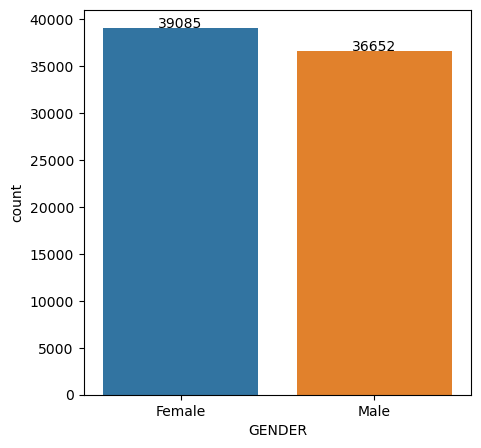

In [39]:
plot_cat(test, 'GENDER')

Chinese    0.708478
Malay      0.122780
Others     0.091593
Indian     0.077149
Name: RACE, dtype: float64


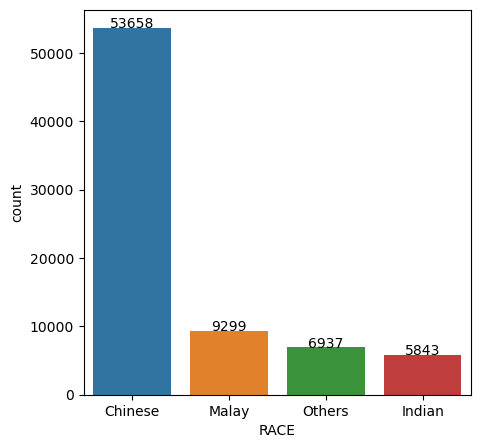

In [41]:
plot_cat(test, 'RACE')

In [19]:
test['HEALTH_No-DHL'] = np.where(test[['Diabetes_Mellitus_Prior', 'Dyslipidaemia_Prior', 'Hypertension_Prior']].sum(axis=1)==0, 1, 0)
test['HEALTH_DHL'] = np.where(test[['Diabetes_Mellitus_Prior', 'Dyslipidaemia_Prior', 'Hypertension_Prior']].sum(axis=1)>0, 1, 0)

No-DHL    0.583532
DHL       0.416468
Name: HEALTH, dtype: float64


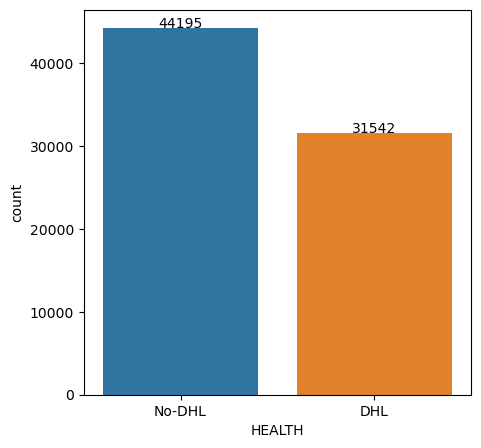

In [42]:
plot_cat(test, 'HEALTH')

In [21]:
test['AGEGROUP_Below50'] = np.where(test['PAT_AGE']<50, 1, 0)
test['AGEGROUP_50andAbove'] = np.where(test['PAT_AGE']>=50, 1, 0)

50andAbove    0.549665
Below50       0.450335
Name: AGEGROUP, dtype: float64


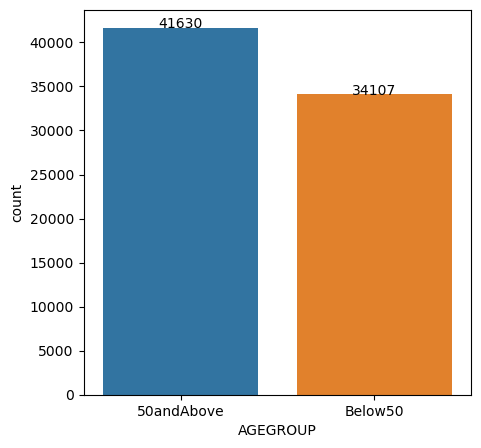

In [43]:
plot_cat(test, 'AGEGROUP')